In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from typing import List

/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 3.1.1-cenagis is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [2]:
from scipy import ndimage

### Paths definition

In [3]:
train_data_directory = r'../train_data'
test_data_directory = r'../test_data'
saved_models_directory = r'../saved_models'
submissions_directory = r'../submissions'

In [4]:
# load data
parameters_values_images_sizes_df = pd.read_csv(os.path.join(train_data_directory, 'DataFrame_parameters_values_images_sizes.csv'))
parameters_values_images_sizes_df

Unnamed: 0  sample_index     P      K     Mg   pH  P_scaled  K_scaled  \
0              0             0  45.1  188.0  179.0  7.2 -0.854435 -0.646288   
1              1             1  44.8  205.0  188.0  7.0 -0.864606 -0.371537   
2              2             2  44.4  207.0  145.0  6.8 -0.878167 -0.339213   
3              3             3  46.5  204.0  143.0  6.8 -0.806972 -0.387699   
4              4             4  52.0  212.0  167.0  6.7 -0.620508 -0.258404   
...          ...           ...   ...    ...    ...  ...       ...       ...   
1727        1727          1727  40.8  133.0  132.0  6.2 -1.000217 -1.535190   
1728        1728          1728  42.7  192.0  126.0  6.5 -0.935802 -0.581641   
1729        1729          1729  39.4  180.0  122.0  6.5 -1.047680 -0.775583   
1730        1730          1730  37.3  162.0  127.0  6.5 -1.118876 -1.066496   
1731        1731          1731  29.5  146.0  133.0  6.3 -1.383316 -1.325086   

      Mg_scaled  pH_scaled  width  length  all_pixels  nonzero_pixels  
0      0.494697   1.603550     11      11         121              79  
1      0.720485   0.834979     11      11         121              78  
2     -0.358282   0.066407     11      11         121              78  
3     -0.408457   0.066407     11      11         121              77  
4      0.193645  -0.317879     11      11         121              78  
...         ...        ...    ...     ...         ...             ...  
1727  -0.684421  -2.239308     66     123        8118            4398  
1728  -0.834947  -1.086451    137     133       18221            9862  
1729  -0.935297  -1.086451    132     130       17160            9193  
1730  -0.809859  -1.086451    125     127       15875            8524  
1731  -0.659333  -1.855022    119     124       14756            7845  

[1732 rows x 14 columns]

In [5]:
parameters_values_images_sizes_df.describe()

Unnamed: 0  sample_index            P            K           Mg  \
count  1732.00000    1732.00000  1732.000000  1732.000000  1732.000000   
mean    865.50000     865.50000    70.302656   227.988510   159.281236   
std     500.12965     500.12965    29.504784    61.891989    39.871829   
min       0.00000       0.00000    20.300000    21.100000    26.800000   
25%     432.75000     432.75000    51.175000   189.000000   134.000000   
50%     865.50000     865.50000    65.100000   216.000000   155.000000   
75%    1298.25000    1298.25000    82.225000   252.000000   181.000000   
max    1731.00000    1731.00000   325.000000   625.000000   400.000000   

                pH      P_scaled      K_scaled     Mg_scaled     pH_scaled  \
count  1732.000000  1.732000e+03  1.732000e+03  1.732000e+03  1.732000e+03   
mean      6.782719 -5.948539e-17  5.743417e-17  1.640976e-16  1.411240e-15   
std       0.260298  1.000289e+00  1.000289e+00  1.000289e+00  1.000289e+00   
min       5.600000 -1.695220e+00 -3.343700e+00 -3.323637e+00 -4.545023e+00   
25%       6.600000 -6.484772e-01 -6.301263e-01 -6.342457e-01 -7.021648e-01   
50%       6.800000 -1.763835e-01 -1.937565e-01 -1.074060e-01  6.640690e-02   
75%       6.900000  4.041984e-01  3.880700e-01  5.448718e-01  4.506927e-01   
max       7.800000  8.634901e+00  6.416439e+00  6.039058e+00  3.909265e+00   

             width       length    all_pixels  nonzero_pixels  
count  1732.000000  1732.000000   1732.000000     1732.000000  
mean     58.103349    58.941109   5648.593533     3347.661085  
std      49.175281    49.462518   6853.659231     3949.142738  
min      11.000000    11.000000    121.000000       73.000000  
25%      11.000000    11.000000    121.000000       79.000000  
50%      42.000000    42.000000   1764.000000     1108.000000  
75%     107.000000   108.000000  11474.250000     7482.250000  
max     268.000000   284.000000  37488.000000    14451.000000

## Try to predict values of single parameter (e.g. P) based on other parameters (e.g. K, Mg, pH)

In [16]:
train_df, test_df = train_test_split(parameters_values_images_sizes_df, test_size=0.3, random_state=22)

### P Parameter

In [27]:
def train_parameters_predict_xgboost(train_df: pd.DataFrame, test_df: pd.DataFrame, parameters_train: List[str], parameter_predict:str):
    X_train, y_train = train_df.loc[:, parameters_train], train_df.loc[:, [parameter_predict]]
    X_test, y_test = test_df.loc[:, parameters_train], test_df.loc[:, [parameter_predict]]
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, n_jobs=-1)
    xg_reg.fit(X_train, y_train)
    
    preds = xg_reg.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
    return mae, mse, rmse, r2

In [28]:
train_parameters_predict_xgboost(train_df, test_df, ['K_scaled', 'Mg_scaled', 'pH_scaled'], 'P_scaled') 

MAE: 0.6243853607004503, MSE: 0.8436191416245064, RMSE: 0.9184874205042257, R2: 0.18755221757168705


(0.6243853607004503,
 0.8436191416245064,
 0.9184874205042257,
 0.18755221757168705)

### K Parameter

In [22]:
temp_gt[['P', 'K', 'Mg', 'pH']].mean(axis=0)

P      70.302656
K     227.988510
Mg    159.281236
pH      6.782719
dtype: float64

In [34]:
train_parameters_predict_xgboost(train_df, test_df, ['P_scaled', 'Mg_scaled', 'pH_scaled'], 'K_scaled') 

MAE: 0.65604422715576, MSE: 0.7873330561596855, RMSE: 0.8873179002813397, R2: 0.1868380330285705


(0.65604422715576, 0.7873330561596855, 0.8873179002813397, 0.1868380330285705)

In [23]:
temp_gt[['P', 'K', 'Mg', 'pH']].median(axis=0)

P      65.1
K     216.0
Mg    155.0
pH      6.8
dtype: float64

### Mg Parameter

In [8]:
temp_gt[['P', 'K', 'Mg', 'pH']].mad(axis=0)

P     20.888682
K     44.693169
Mg    30.087340
pH     0.200171
dtype: float64

In [30]:
train_parameters_predict_xgboost(train_df, test_df, ['P_scaled', 'K_scaled', 'pH_scaled'], 'Mg_scaled') 

MAE: 0.7083866990240879, MSE: 0.8826402346503285, RMSE: 0.9394893478109949, R2: 0.1209786784622563


(0.7083866990240879,
 0.8826402346503285,
 0.9394893478109949,
 0.1209786784622563)

In [9]:
temp_gt[['P', 'K', 'Mg', 'pH']].var(axis=0)

P      870.532298
K     3830.618360
Mg    1589.762761
pH       0.067755
dtype: float64

### pH Parameter

In [13]:
# List with image files
img_files = np.array(
            sorted(
                glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
img_files

array(['../train_data/train_data/0.npz', '../train_data/train_data/1.npz',
       '../train_data/train_data/2.npz', ...,
       '../train_data/train_data/1729.npz',
       '../train_data/train_data/1730.npz',
       '../train_data/train_data/1731.npz'], dtype='<U33')

In [31]:
train_parameters_predict_xgboost(train_df, test_df, ['P_scaled', 'K_scaled', 'Mg_scaled'], 'pH_scaled') 

MAE: 0.7624207514458379, MSE: 0.9769007742600778, RMSE: 0.9883829087251953, R2: 0.017904903485254642


(0.7624207514458379,
 0.9769007742600778,
 0.9883829087251953,
 0.017904903485254642)

In [69]:
images_sizes = dict()
for i in range(0, img_files.shape[0]):
    img_arr = np.ma.MaskedArray(**np.load(img_files[i]))
    img_width_length = img_arr.shape[1:3]
    
    img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
    # Inverting mask is necessary due to masking method in numpy
    img_tensor_mask = ~torch.as_tensor(img_arr.mask)
    img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
    
    nonzero_pixels = img_masked_tensor[0].count_nonzero().item()
    all_pixels = img_width_length[0] * img_width_length[1]
    
    images_sizes[i] = [img_width_length[0], img_width_length[1], all_pixels, nonzero_pixels]
    
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [103]:
images_sizes_df = pd.DataFrame.from_dict({ key: pd.Series(val) for key, val in images_sizes.items() }, orient='index')
images_sizes_df.rename(columns={0:'width', 1:'length', 2:'all_pixels', 3:'nonzero_pixels'}, inplace=True)
images_sizes_df

width  length  all_pixels  nonzero_pixels
0        11      11         121              79
1        11      11         121              78
2        11      11         121              78
3        11      11         121              77
4        11      11         121              78
...     ...     ...         ...             ...
1727     66     123        8118            4398
1728    137     133       18221            9862
1729    132     130       17160            9193
1730    125     127       15875            8524
1731    119     124       14756            7845

[1732 rows x 4 columns]

In [132]:
parameters_values_images_sizes_df = pd.concat([temp_gt, images_sizes_df], axis=1)
parameters_values_images_sizes_df

sample_index     P      K     Mg   pH  P_scaled  K_scaled  Mg_scaled  \
0                0  45.1  188.0  179.0  7.2 -0.854435 -0.646288   0.494697   
1                1  44.8  205.0  188.0  7.0 -0.864606 -0.371537   0.720485   
2                2  44.4  207.0  145.0  6.8 -0.878167 -0.339213  -0.358282   
3                3  46.5  204.0  143.0  6.8 -0.806972 -0.387699  -0.408457   
4                4  52.0  212.0  167.0  6.7 -0.620508 -0.258404   0.193645   
...            ...   ...    ...    ...  ...       ...       ...        ...   
1727          1727  40.8  133.0  132.0  6.2 -1.000217 -1.535190  -0.684421   
1728          1728  42.7  192.0  126.0  6.5 -0.935802 -0.581641  -0.834947   
1729          1729  39.4  180.0  122.0  6.5 -1.047680 -0.775583  -0.935297   
1730          1730  37.3  162.0  127.0  6.5 -1.118876 -1.066496  -0.809859   
1731          1731  29.5  146.0  133.0  6.3 -1.383316 -1.325086  -0.659333   

      pH_scaled  width  length  all_pixels  nonzero_pixels  
0      1.603550     11      11         121              79  
1      0.834979     11      11         121              78  
2      0.066407     11      11         121              78  
3      0.066407     11      11         121              77  
4     -0.317879     11      11         121              78  
...         ...    ...     ...         ...             ...  
1727  -2.239308     66     123        8118            4398  
1728  -1.086451    137     133       18221            9862  
1729  -1.086451    132     130       17160            9193  
1730  -1.086451    125     127       15875            8524  
1731  -1.855022    119     124       14756            7845  

[1732 rows x 13 columns]

In [133]:
# save DataFrame to csv
parameters_values_images_sizes_df.to_csv(os.path.join(train_data_directory, 'DataFrame_parameters_values_images_sizes.csv'))

In [134]:
parameters_values_images_sizes_df.describe()

sample_index            P            K           Mg           pH  \
count    1732.00000  1732.000000  1732.000000  1732.000000  1732.000000   
mean      865.50000    70.302656   227.988510   159.281236     6.782719   
std       500.12965    29.504784    61.891989    39.871829     0.260298   
min         0.00000    20.300000    21.100000    26.800000     5.600000   
25%       432.75000    51.175000   189.000000   134.000000     6.600000   
50%       865.50000    65.100000   216.000000   155.000000     6.800000   
75%      1298.25000    82.225000   252.000000   181.000000     6.900000   
max      1731.00000   325.000000   625.000000   400.000000     7.800000   

           P_scaled      K_scaled     Mg_scaled     pH_scaled        width  \
count  1.732000e+03  1.732000e+03  1.732000e+03  1.732000e+03  1732.000000   
mean  -5.743417e-17  5.743417e-17  1.723025e-16  1.411240e-15    58.103349   
std    1.000289e+00  1.000289e+00  1.000289e+00  1.000289e+00    49.175281   
min   -1.695220e+00 -3.343700e+00 -3.323637e+00 -4.545023e+00    11.000000   
25%   -6.484772e-01 -6.301263e-01 -6.342457e-01 -7.021648e-01    11.000000   
50%   -1.763835e-01 -1.937565e-01 -1.074060e-01  6.640690e-02    42.000000   
75%    4.041984e-01  3.880700e-01  5.448718e-01  4.506927e-01   107.000000   
max    8.634901e+00  6.416439e+00  6.039058e+00  3.909265e+00   268.000000   

            length    all_pixels  nonzero_pixels  
count  1732.000000   1732.000000     1732.000000  
mean     58.941109   5648.593533     3347.661085  
std      49.462518   6853.659231     3949.142738  
min      11.000000    121.000000       73.000000  
25%      11.000000    121.000000       79.000000  
50%      42.000000   1764.000000     1108.000000  
75%     108.000000  11474.250000     7482.250000  
max     284.000000  37488.000000    14451.000000

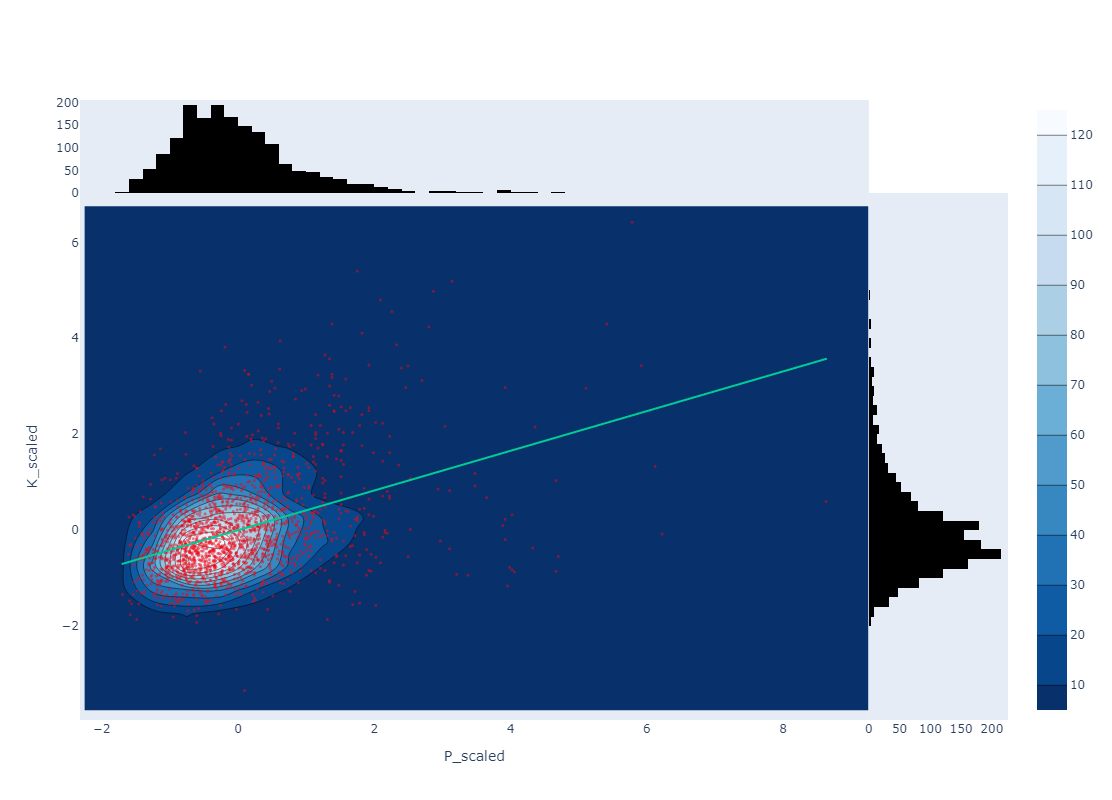

In [205]:
create_plot_histogram_scatter('P_scaled', 'K_scaled')

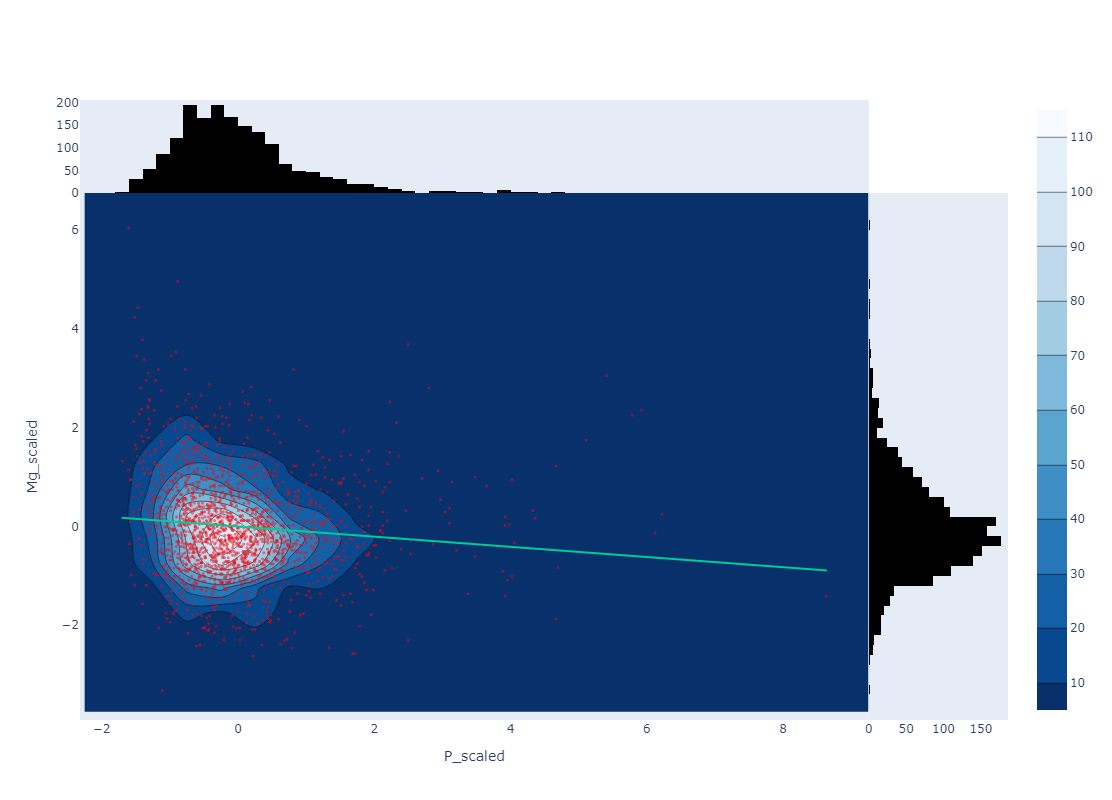

In [206]:
create_plot_histogram_scatter('P_scaled', 'Mg_scaled')

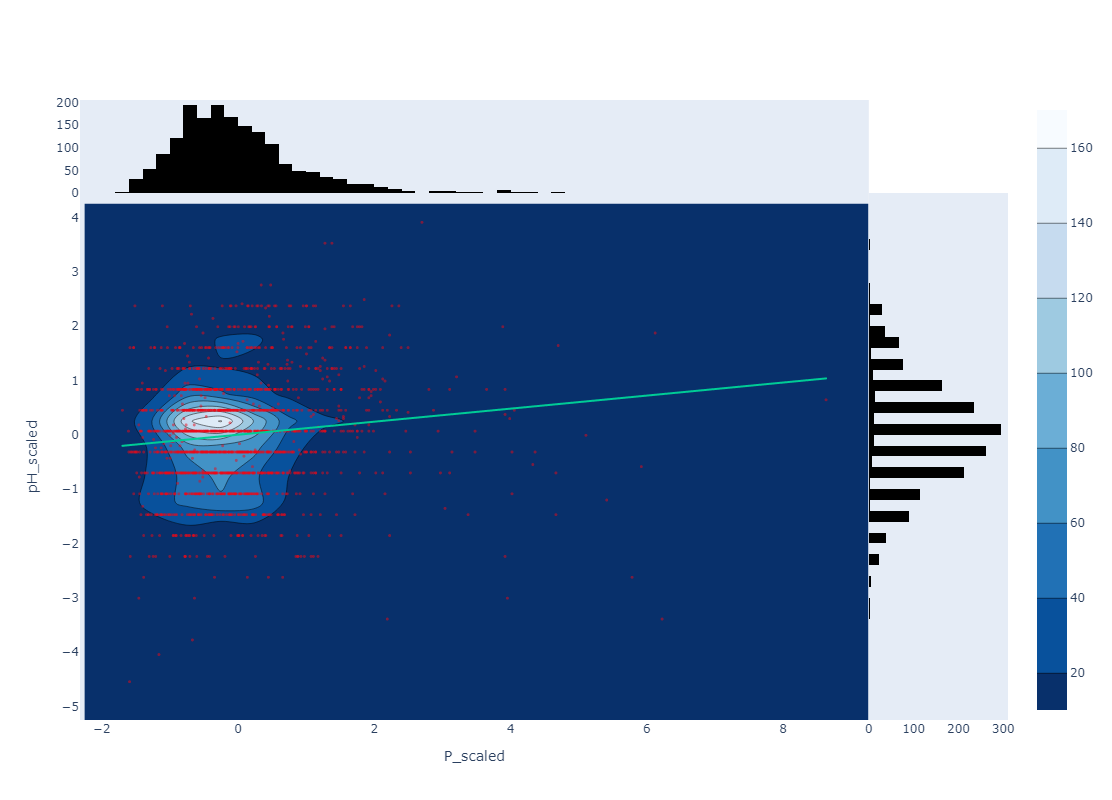

In [207]:
create_plot_histogram_scatter('P_scaled', 'pH_scaled')

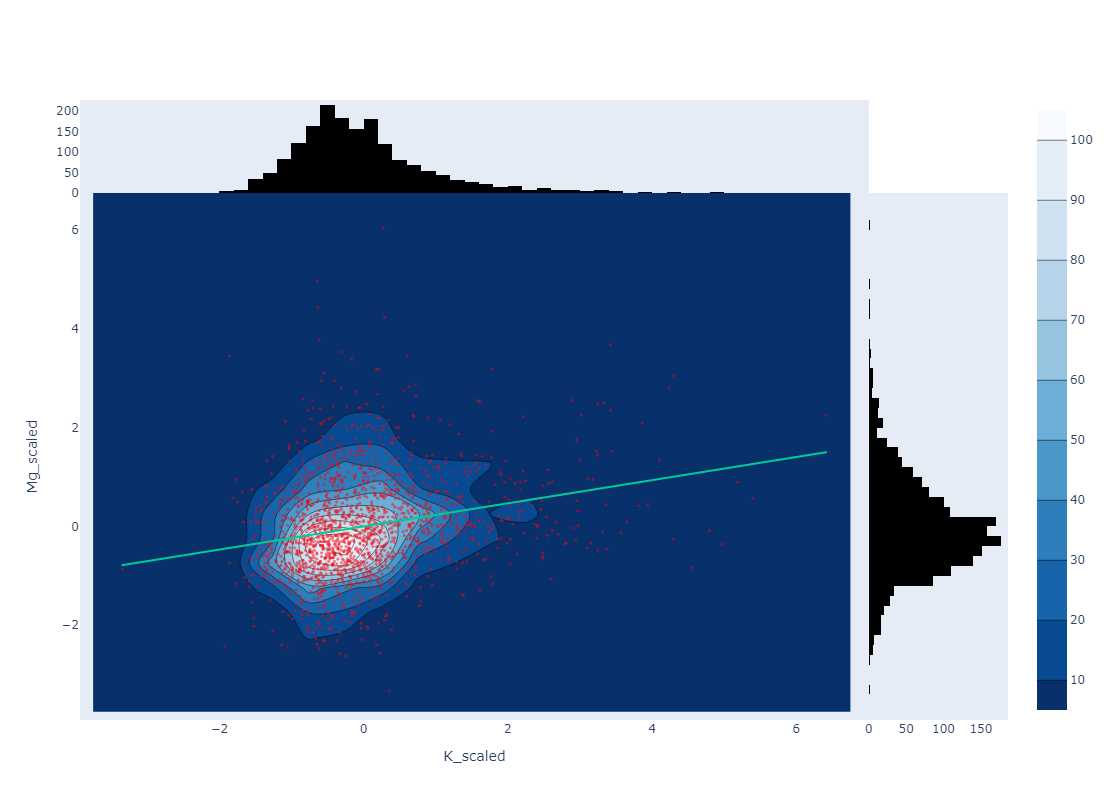

In [219]:
create_plot_histogram_scatter('K_scaled', 'Mg_scaled')

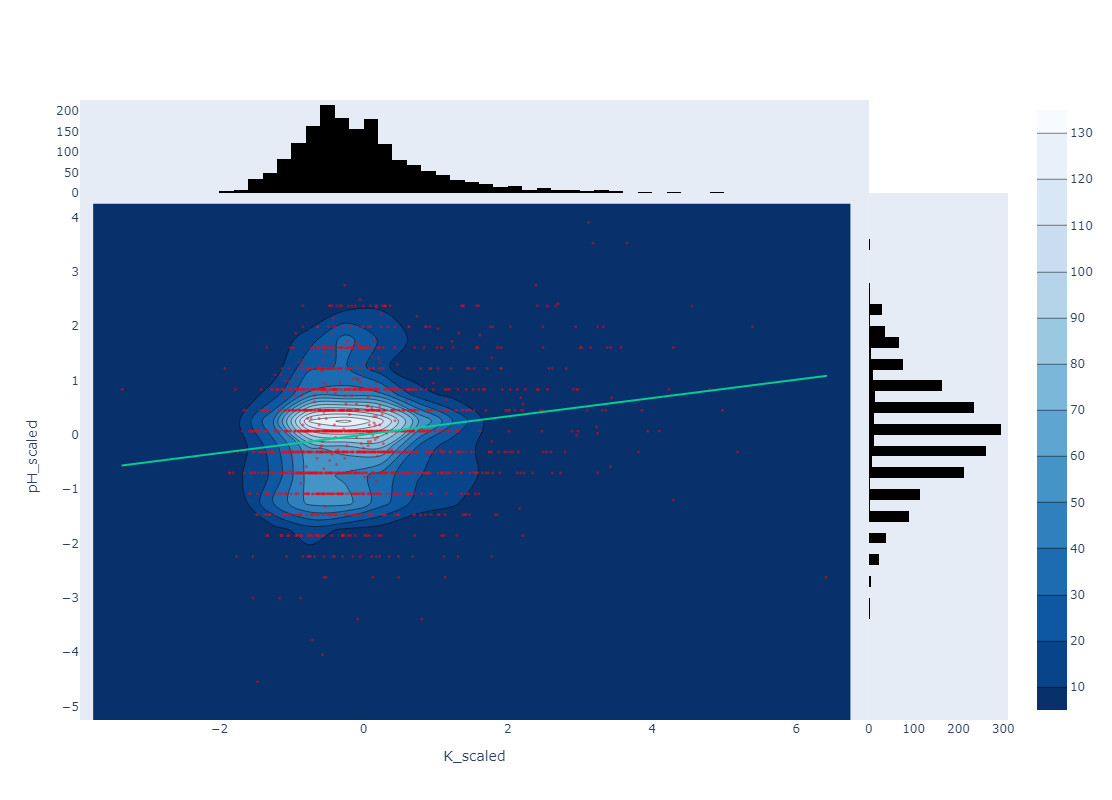

In [209]:
create_plot_histogram_scatter('K_scaled', 'pH_scaled')

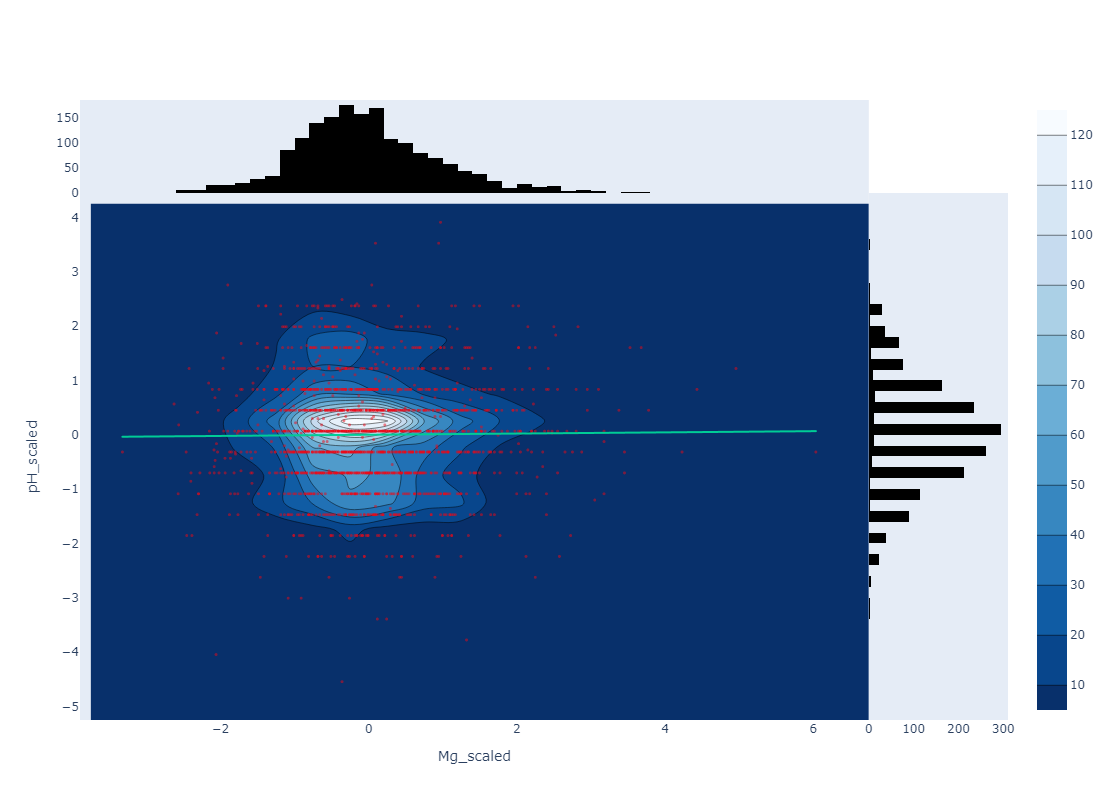

In [210]:
create_plot_histogram_scatter('Mg_scaled', 'pH_scaled')

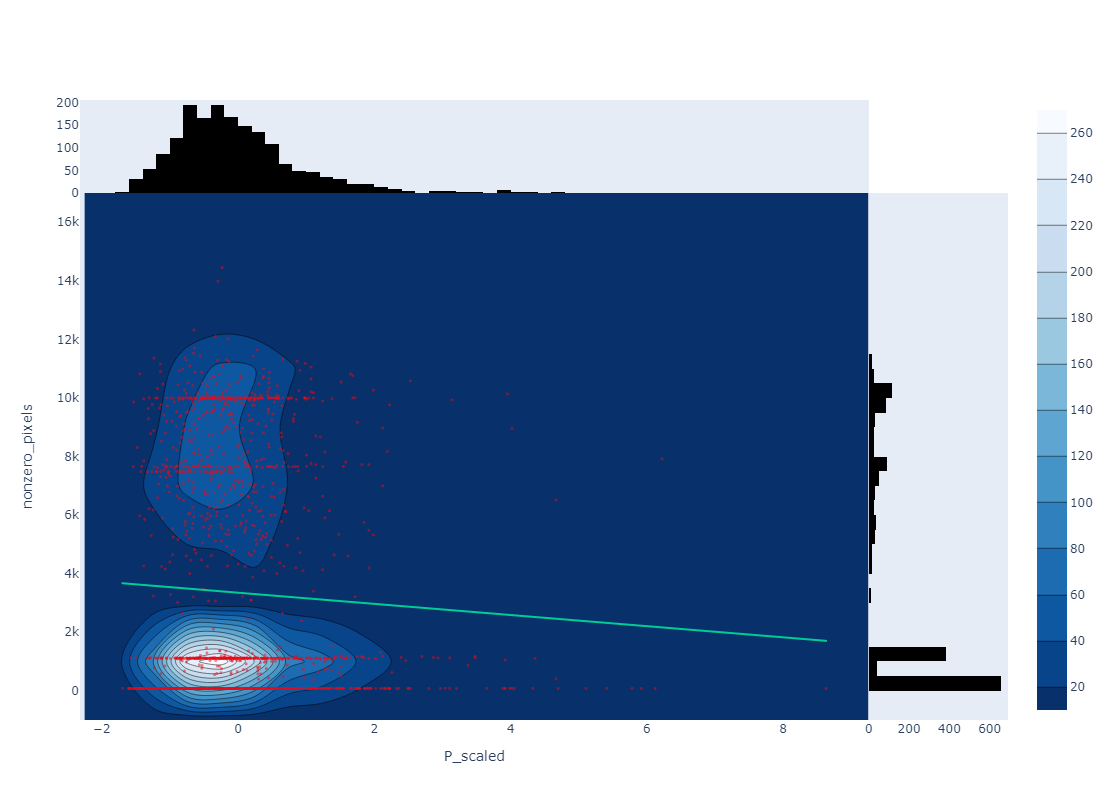

In [218]:
create_plot_histogram_scatter('P_scaled', 'nonzero_pixels')

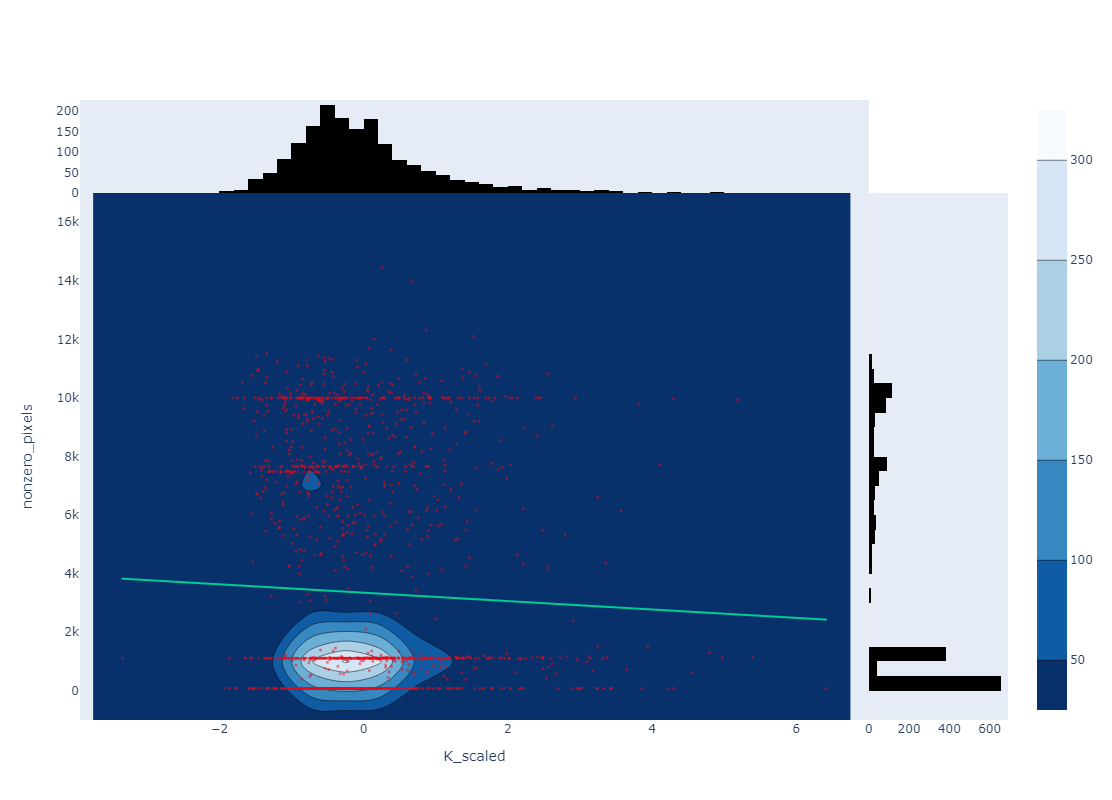

In [214]:
create_plot_histogram_scatter('K_scaled', 'nonzero_pixels')

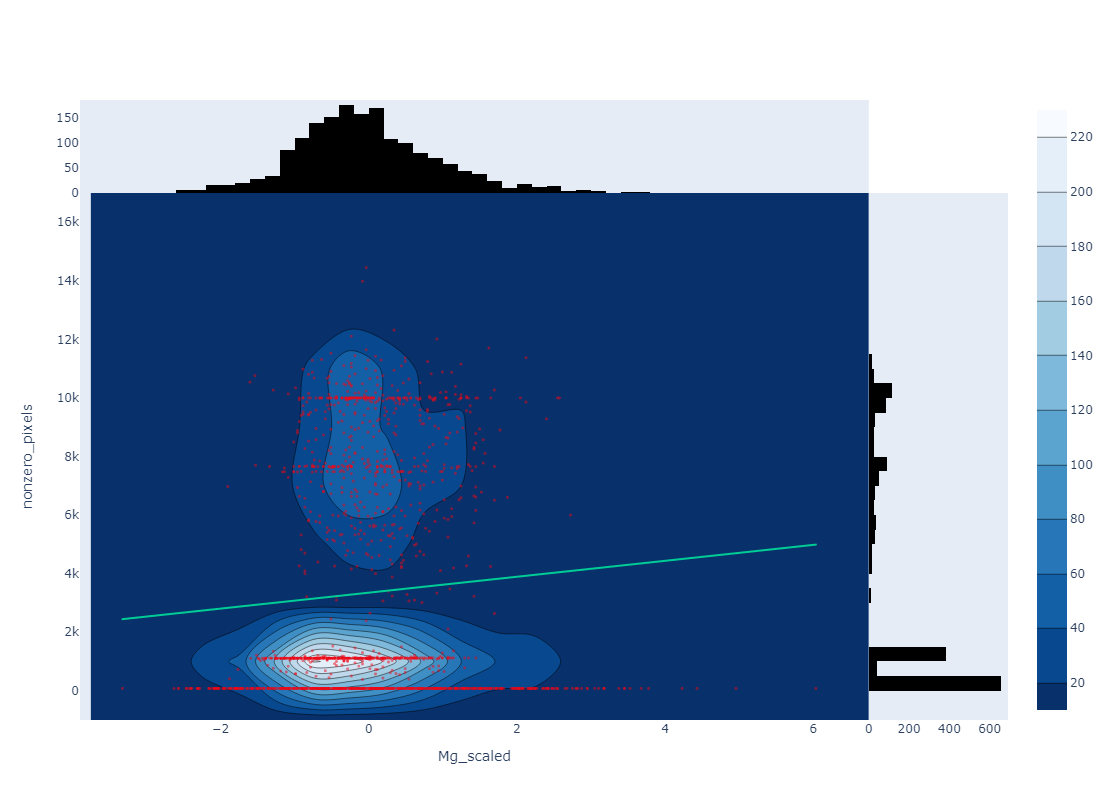

In [215]:
create_plot_histogram_scatter('Mg_scaled', 'nonzero_pixels')

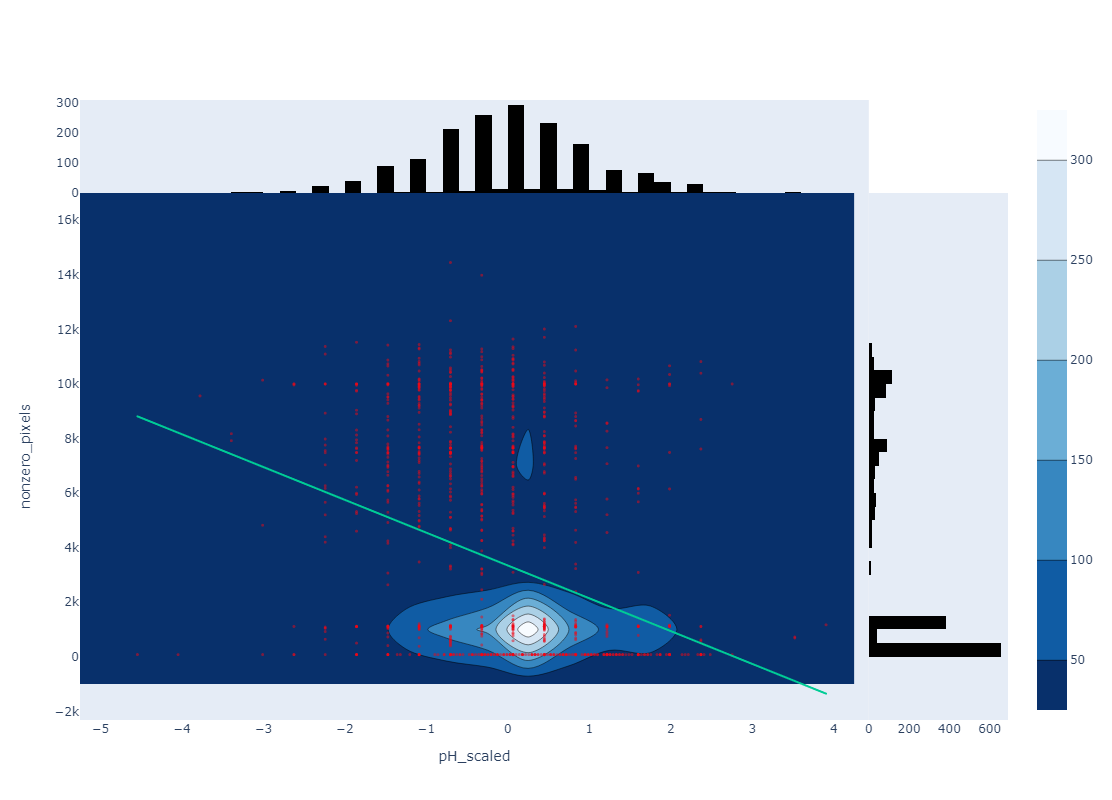

In [216]:
create_plot_histogram_scatter('pH_scaled', 'nonzero_pixels')